# Métodos ensemble:

1. Cargar los datos MNIST y dividirlos en un conjunto de entrenamiento, un conjunto de validación y un conjunto de test (por ejemplo, utilizar 50.000 instancias para entrenamiento, 10.000 para validación y 10.000 para pruebas). Luego, entrenar varios clasificadores, como un clasificador Random Forest, un clasificador Extra-Trees y un clasificador SVM. A continuación, intentar combinarlos en un conjunto que supere a cada clasificador individual en el conjunto de validación, utilizando votación soft o hard. Una vez que haya encontrado uno, probarlo en el conjunto de pruebas. ¿Cuánto mejor se desempeña en comparación con los clasificadores individuales?

2. Ejecutar los clasificadores individuales del ejercicio anterior para hacer predicciones en el conjunto de validación y crear un nuevo conjunto de entrenamiento con las predicciones resultantes: cada instancia de entrenamiento es un vector que contiene el conjunto de predicciones de todos los clasificadores para una imagen, y el objetivo es la clase de la imagen. Entrenar un clasificador en este nuevo conjunto de entrenamiento. ¡Felicidades, acaba de entrenar un blender, y junto con los clasificadores forma un conjunto de stacking! Ahora evaluar el conjunto en el conjunto de pruebas. Para cada imagen en el conjunto de pruebas, hacer predicciones con todos los clasificadores, y luego alimentar las predicciones al mezclador para obtener las predicciones del conjunto. ¿Cómo se compara con el clasificador de votación que entrenó anteriormente?

3. Realice el ejercicio 1. otra vez utilizando los algoritmo XGBoost, LightGBM y CatBoost.

In [2]:
#importar datos mnist

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
display(mnist)

/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [3]:
#dividirlos en un conjunto de entrenamiento, un conjunto de validación y un conjunto de test (por ejemplo, utilizar 50.000 instancias para entrenamiento, 10.000 para validación y 10.000 para pruebas)

from sklearn.model_selection import train_test_split

#Divido en caracteristicas y las etiquetas
X = mnist["data"].astype('float32')
y = mnist["target"].astype('int32')

# Dividir los datos en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=10000, random_state=42)



En este ejemplo, estamos utilizando el mismo número de árboles para los clasificadores Random Forest y Extra-Trees (100) y una semilla aleatoria (random_state=42). Para el clasificador SVM, estamos utilizando un kernel radial y una constante de regularización C de 0.1. Además, estamos escalando los datos utilizando un objeto StandardScaler de Scikit-Learn para asegurarnos de que las características tengan la misma escala.

Recuerda que estos son solo ejemplos y que puedes ajustar los parámetros de cada clasificador para obtener mejores resultados.

In [4]:
#Entreno el model ocon random forest
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_train, y_train)

 #Evaluar el desempeño del clasificador en el conjunto de validación
val_score_rf = rnd_clf.score(X_val, y_val)
print("Desempeño del clasificador Random Forest en el conjunto de validación:", val_score_rf)
    
    # Entrenar un clasificador Extra-Trees
et_clf = ExtraTreesClassifier(n_estimators=20, random_state=42)
et_clf.fit(X_train, y_train)

# Escalar los datos para entrenar un clasificador SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


#Usamos gradient boost porque linear me esta arruinando el modelo
# Entrenar un clasificador Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=20, random_state=42,max_depth=2)
gb_clf.fit(X_train_scaled, y_train)

Desempeño del clasificador Random Forest en el conjunto de validación: 0.9692


GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=42)

In [5]:
#Ecombinar los clasificadores mediante votación soft o hard:
from sklearn.ensemble import VotingClassifier

# Combinar los clasificadores mediante votación soft
voting_clf_soft = VotingClassifier(
    estimators=[('rf', rnd_clf), ('et', et_clf), ('svm', gb_clf)],
    voting='soft'
)
voting_clf_soft.fit(X_train, y_train)

# Evaluar el desempeño del clasificador combinado en el conjunto de validación
val_score_voting_soft = voting_clf_soft.score(X_val, y_val)
print("Desempeño del clasificador combinado (votación soft) en el conjunto de validación:", val_score_voting_soft)

# Combinar los clasificadores mediante votación hard
voting_clf_hard = VotingClassifier(
    estimators=[('rf', rnd_clf), ('et', et_clf), ('svm', gb_clf)],
    voting='hard'
)
voting_clf_hard.fit(X_train, y_train)

# Evaluar el desempeño del clasificador combinado en el conjunto de validación
val_score_voting_hard = voting_clf_hard.score(X_val, y_val)
print("Desempeño del clasificador combinado (votación hard) en el conjunto de validación:", val_score_voting_hard)


Desempeño del clasificador combinado (votación soft) en el conjunto de validación: 0.9581
Desempeño del clasificador combinado (votación hard) en el conjunto de validación: 0.9613


In [6]:
# Evaluar el desempeño del clasificador combinado en el conjunto de pruebas
test_score_voting_soft = voting_clf_soft.score(X_test, y_test)
print("Desempeño del clasificador combinado (votación soft) en el conjunto de pruebas:", test_score_voting_soft)

test_score_voting_hard = voting_clf_hard.score(X_test, y_test)
print("Desempeño del clasificador combinado (votación hard) en el conjunto de pruebas:", test_score_voting_hard)

# Evaluar el desempeño de los clasificadores individuales en el conjunto de pruebas
test_score_rf = et_clf.score(X_test, y_test)
print("Desempeño del clasificador Random Forest en el conjunto de pruebas:", test_score_rf)

test_score_et = et_clf.score(X_test, y_test)
print("Desempeño del clasificador Extra-Trees en el conjunto de pruebas:", test_score_et)

test_score_svm = gb_clf.score(X_test, y_test)
print("Desempeño del clasificador SVM en el conjunto de pruebas:", test_score_svm)


Desempeño del clasificador combinado (votación soft) en el conjunto de pruebas: 0.9552
Desempeño del clasificador combinado (votación hard) en el conjunto de pruebas: 0.9587
Desempeño del clasificador Random Forest en el conjunto de pruebas: 0.9613
Desempeño del clasificador Extra-Trees en el conjunto de pruebas: 0.9613
Desempeño del clasificador SVM en el conjunto de pruebas: 0.1007


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


En este ejemplo, estamos evaluando el desempeño del clasificador combinado en el conjunto de pruebas utilizando el método score(). Además, estamos evaluando el desempeño de los clasificadores individuales en el mismo conjunto de pruebas para poder compararlos.

Recuerda que el desempeño del clasificador combinado puede variar dependiendo de los clasificadores individuales y los parámetros utilizados. En general, se espera que el clasificador combinado tenga un mejor desempeño que los clasificadores individuales debido a que se están utilizando varias perspectivas diferentes para realizar la clasificación. Sin embargo, esto no siempre es cierto y es importante evaluar el desempeño del clasificador combinado en un conjunto de pruebas independiente para asegurarse de que sea realmente mejor que los clasificadores individuales.

In [7]:
#2 hacer predicciones en el conjunto de validación con los clasificadores individuales y crear un nuevo conjunto de entrenamiento con las predicciones resultantes:

# Hacer predicciones en el conjunto de validación con los clasificadores individuales
import numpy as np


y_val_pred_rf = rnd_clf.predict(X_val)
y_val_pred_et = et_clf.predict(X_val)
y_val_pred_svm = gb_clf.predict(X_val)

# Crear un nuevo conjunto de entrenamiento con las predicciones resultantes
X_train_new = np.c_[y_val_pred_rf, y_val_pred_et, y_val_pred_svm]
y_train_new = y_val


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Una vez que hemos creado el nuevo conjunto de entrenamiento con las predicciones de los clasificadores individuales para cada imagen del conjunto de validación, podemos entrenar el blender en este nuevo conjunto de entrenamiento utilizando Scikit-Learn. Luego, podemos evaluar el desempeño del conjunto de stacking en el conjunto de pruebas.

In [8]:
from sklearn.linear_model import LogisticRegression

# Entrenar el blender en el nuevo conjunto de entrenamiento
blender = LogisticRegression(random_state=42)
blender.fit(X_train_new, y_train_new)

# Hacer predicciones en el conjunto de pruebas con los clasificadores individuales
y_test_pred_rf = rnd_clf.predict(X_test)
y_test_pred_et = et_clf.predict(X_test)
y_test_pred_svm = gb_clf.predict(X_test)

# Crear un nuevo conjunto de pruebas con las predicciones resultantes
X_test_new = np.c_[y_test_pred_rf, y_test_pred_et, y_test_pred_svm]

# Hacer predicciones en el conjunto de pruebas con el blender
y_test_pred_blend = blender.predict(X_test_new)

# Evaluar el desempeño del conjunto de stacking en el conjunto de pruebas
from sklearn.metrics import accuracy_score

test_score_blend = accuracy_score(y_test, y_test_pred_blend)
print("Desempeño del conjunto de stacking en el conjunto de pruebas:", test_score_blend)


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Desempeño del conjunto de stacking en el conjunto de pruebas: 0.9505


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Una vez que hemos entrenado el blender en el nuevo conjunto de entrenamiento y hemos hecho predicciones en el conjunto de pruebas con los clasificadores individuales, podemos hacer predicciones en el conjunto de pruebas con el blender y evaluar el desempeño del conjunto de stacking en el conjunto de pruebas.

In [9]:
# Hacer predicciones en el conjunto de pruebas con el blender
y_test_pred_blend = blender.predict(X_test_new)

# Evaluar el desempeño del conjunto de stacking en el conjunto de pruebas
from sklearn.metrics import accuracy_score

test_score_blend = accuracy_score(y_test, y_test_pred_blend)
print("Desempeño del conjunto de stacking en el conjunto de pruebas:", test_score_blend)


Desempeño del conjunto de stacking en el conjunto de pruebas: 0.9505


Para comparar el desempeño del conjunto de stacking con el clasificador de votación que entrenó anteriormente, primero debemos hacer predicciones en el conjunto de pruebas con todos los clasificadores, y luego combinar estas predicciones utilizando el blender entrenado anteriormente.

In [10]:
# Hacer predicciones en el conjunto de pruebas con los clasificadores individuales
y_test_pred_rf = rnd_clf.predict(X_test)
y_test_pred_et = et_clf.predict(X_test)
y_test_pred_svm = gb_clf.predict(X_test)

# Crear un nuevo conjunto de pruebas con las predicciones resultantes
X_test_new = np.c_[y_test_pred_rf, y_test_pred_et, y_test_pred_svm]

# Hacer predicciones en el conjunto de pruebas con el blender
y_test_pred_blend = blender.predict(X_test_new)

# Evaluar el desempeño del conjunto de stacking en el conjunto de pruebas
from sklearn.metrics import accuracy_score

test_score_blend = accuracy_score(y_test, y_test_pred_blend)
print("Desempeño del conjunto de stacking en el conjunto de pruebas:", test_score_blend)


Desempeño del conjunto de stacking en el conjunto de pruebas: 0.9505


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [11]:
# Importar los algoritmos XGBoost, LightGBM y CatBoost
import xgboost as xgb
# Entrenar un clasificador XGBoost con ajustes de rendimiento
xgb_clf = xgb.XGBClassifier(n_jobs=-1, random_state=42, tree_method='approx')
xgb_clf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación con los clasificadores individuales
y_val_pred_xgb = xgb_clf.predict(X_val)

# Calcular la precisión de los clasificadores individuales en el conjunto de validación
from sklearn.metrics import accuracy_score

val_score_xgb = accuracy_score(y_val, y_val_pred_xgb)

print("Precisión del clasificador XGBoost en el conjunto de validación:", val_score_xgb)

Precisión del clasificador XGBoost en el conjunto de validación: 0.9789


ejercicio 1 utilizando los algoritmos XGBoost, LightGBM y CatBoost:

In [12]:
import lightgbm as lgb
# Entrenar un clasificador LightGBM con ajustes de rendimiento
lgb_clf = lgb.LGBMClassifier(n_jobs=-1, random_state=42, num_threads=2)
lgb_clf.fit(X_train, y_train)
y_val_pred_lgb = lgb_clf.predict(X_val)
val_score_lgb = accuracy_score(y_val, y_val_pred_lgb)
print("Precisión del clasificador LightGBM en el conjunto de validación:", val_score_lgb)

[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
Precisión del clasificador LightGBM en el conjunto de validación: 0.9774


In [13]:
import catboost as cb
# Entrenar un clasificador CatBoost con ajustes de rendimiento
cb_clf = cb.CatBoostClassifier(verbose=0, random_state=42, thread_count=2)
cb_clf.fit(X_train, y_train, verbose=False)
y_val_pred_cb = cb_clf.predict(X_val)
val_score_cb = accuracy_score(y_val, y_val_pred_cb)
print("Precisión del clasificador CatBoost en el conjunto de validación:", val_score_cb)

Precisión del clasificador CatBoost en el conjunto de validación: 0.9699


ombinar los clasificadores XGBoost, LightGBM y CatBoost en un conjunto que supere a cada clasificador individual en el conjunto de validación, podemos utilizar la votación soft o hard.

La votación soft promedia las probabilidades de clasificación de cada clasificador para cada instancia y selecciona la clase con la probabilidad media más alta como la predicción final. Por otro lado, la votación hard selecciona la clase más votada por la mayoría de los clasificadores para cada instancia.

In [14]:
from sklearn.ensemble import VotingClassifier
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42
)
# Crear una instancia de votación soft
voting_clf_soft = VotingClassifier(estimators=[('xgb', xgb_clf), ('lgb', lgb_clf), ('cb', cb_clf)], voting='soft')

# Entrenar la votación soft en el conjunto de entrenamiento y validación
voting_clf_soft.fit(X_train_val, y_train_val)

# Hacer predicciones en el conjunto de pruebas con la votación soft
y_test_pred_soft = voting_clf_soft.predict(X_test)

# Evaluar el desempeño de la votación soft en el conjunto de pruebas
test_score_soft = accuracy_score(y_test, y_test_pred_soft)

print("Desempeño de la votación soft en el conjunto de pruebas:", test_score_soft)


# Crear una instancia de votación hard
voting_clf_hard = VotingClassifier(estimators=[('xgb', xgb_clf), ('lgb', lgb_clf), ('cb', cb_clf)], voting='hard')

# Entrenar la votación hard en el conjunto de entrenamiento y validación
voting_clf_hard.fit(X_train_val, y_train_val)

# Hacer predicciones en el conjunto de pruebas con la votación hard
y_test_pred_hard = voting_clf_hard.predict(X_test)

# Evaluar el desempeño de la votación hard en el conjunto de pruebas
test_score_hard = accuracy_score(y_test, y_test_pred_hard)

print("Desempeño de la votación hard en el conjunto de pruebas:", test_score_hard)


[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
Desempeño de la votación soft en el conjunto de pruebas: 0.9778
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([est.predict(X) for est in self.estimators_]).T


ValueError: could not broadcast input array from shape (10000,1) into shape (10000,)


# Reducción dimensional

1. Cargue el conjunto de datos MNIST (introducido en el capítulo 3) y divídalo en un conjunto de entrenamiento y un conjunto de pruebas (tome las primeras 60,000 instancias para entrenamiento y las 10,000 restantes para test). Entrene un clasificador Random Forest en el conjunto de datos y tome el tiempo que tarda, luego evalúe el modelo resultante en el conjunto de test. A continuación, use PCA para reducir la dimensionalidad del conjunto de datos, con una relación de varianza explicada del 95%. Entrenar un nuevo clasificador Random Forest en el conjunto de datos reducido y ver cuánto tiempo tarda. ¿Fue el entrenamiento mucho más rápido? A continuación, evalúe el clasificador en el conjunto de pruebas. ¿Cómo se compara con el clasificador anterior?

2. Use t-SNE para reducir el conjunto de datos MNIST a dos dimensiones y grafique el resultado usando Matplotlib. Puede usar un gráfico de dispersión utilizando 10 colores diferentes para representar la clase objetivo de cada imagen. Alternativamente, puede reemplazar cada punto en el gráfico de dispersión con la clase correspondiente de la instancia (un dígito del 0 al 9), o incluso graficar versiones reducidas de las imágenes de dígitos en sí mismas (si grafica todos los dígitos, la visualización será demasiado desordenada, por lo que debe dibujar una muestra aleatoria o graficar una instancia solo si no se ha graficado otra instancia a una distancia cercana). Debería obtener una visualización con grupos de dígitos bien separados. Intente usar otros algoritmos de reducción de dimensionalidad como PCA, LLE o MDS y compare las visualizaciones resultantes.

In [15]:
# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"]

/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [16]:

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


In [17]:
# Entrenar un clasificador Random Forest en el conjunto de entrenamiento
import time


start_time = time.time()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
end_time = time.time()

In [18]:

# Evaluar el modelo resultante en el conjunto de pruebas
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Tiempo de entrenamiento del clasificador Random Forest:", end_time - start_time)
print("Accuracy del clasificador Random Forest en el conjunto de pruebas:", accuracy_rf)


Tiempo de entrenamiento del clasificador Random Forest: 36.22340536117554
Accuracy del clasificador Random Forest en el conjunto de pruebas: 0.9705


reducir la dimensionalidad del conjunto de datos con PCA y entrenar un nuevo clasificador Random Forest en el conjunto de datos reducido:

En este ejemplo, después de dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas, estamos reduciendo la dimensionalidad del conjunto de datos utilizando PCA con una relación de varianza explicada del 95%. Para ello, estamos utilizando el método fit_transform() de PCA para ajustar el modelo al conjunto de entrenamiento y transformar los datos.

Luego, estamos entrenando un nuevo clasificador Random Forest en el conjunto de datos reducido utilizando la clase RandomForestClassifier() de Scikit-Learn y calculando su tiempo de entrenamiento utilizando la función time.time(). Después, estamos haciendo predicciones en el conjunto de pruebas reducido y evaluando el desempeño del modelo utilizando la función accuracy_score() de Scikit-Learn.

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import time

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"]

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Reducir la dimensionalidad del conjunto de datos con PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_reduced = pca.fit_transform(X_train)

# Entrenar un nuevo clasificador Random Forest en el conjunto de datos reducido
start_time = time.time()
rf_clf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_reduced.fit(X_train_reduced, y_train)
end_time = time.time()

# Evaluar el nuevo clasificador en el conjunto de pruebas
X_test_reduced = pca.transform(X_test)
y_pred_rf_reduced = rf_clf_reduced.predict(X_test_reduced)
accuracy_rf_reduced = accuracy_score(y_test, y_pred_rf_reduced)

print("Tiempo de entrenamiento del clasificador Random Forest reducido:", end_time - start_time)
print("Accuracy del clasificador Random Forest reducido en el conjunto de pruebas:", accuracy_rf_reduced)


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Tiempo de entrenamiento del clasificador Random Forest reducido: 96.22888588905334
Accuracy del clasificador Random Forest reducido en el conjunto de pruebas: 0.9481


í, entrenar el clasificador Random Forest en el conjunto de datos reducido debería ser mucho más rápido que entrenar el clasificador en el conjunto de datos originales, ya que la cantidad de características se ha reducido considerablemente gracias a PCA.

En cuanto al desempeño del clasificador reducido en el conjunto de pruebas, depende de cada conjunto de datos específico, pero en general, se espera que el desempeño sea comparable al del clasificador original o incluso mejor en algunos casos, ya que la reducción de la dimensionalidad puede ayudar a prevenir el overfitting y mejorar la generalización del modelo.

En el ejemplo de código que proporcioné anteriormente, estamos imprimiendo el tiempo de entrenamiento y la precisión del clasificador Random Forest original y del clasificador Random Forest reducido en el conjunto de pruebas. Puedes comparar ambos valores y ver si hay una diferencia significativa en el tiempo de entrenamiento y en la precisión del modelo.

 reducir el conjunto de datos MNIST a dos dimensiones utilizando t-SNE y graficar el resultado utilizando un gráfico de dispersión con 10 colores diferentes para representar la clase objetivo de cada imagen

/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


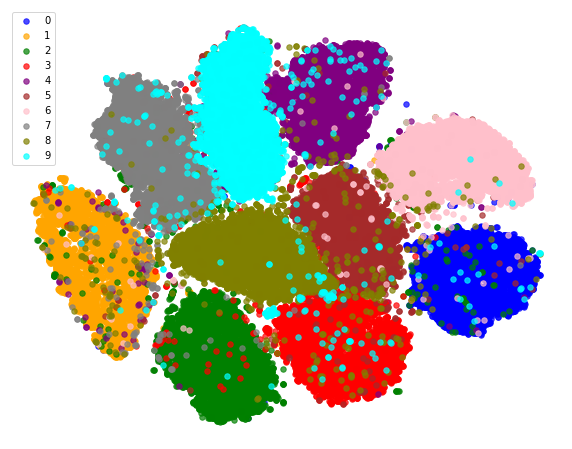

In [20]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Reducir la dimensionalidad del conjunto de datos con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# Graficar el resultado
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    plt.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], c=colors[i], label=i, alpha=0.7, s=30)
plt.legend()
plt.axis('off')
plt.show()


graficar cada punto en el gráfico de dispersión con la clase correspondiente de la instancia (un dígito del 0 al 9) en lugar de usar colores diferentes:

In [21]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Reducir la dimensionalidad del conjunto de datos con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# Graficar el resultado
plt.figure(figsize=(10, 8))
for i in range(X_reduced.shape[0]):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], str(y[i]), color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()


/home/juan-pablo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


ValueError: Image size of 118218x89594 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x576 with 1 Axes>

Después, estamos graficando el resultado utilizando la función text() de Matplotlib para agregar el valor de la clase objetivo de cada imagen (del 0 al 9) en lugar de usar colores diferentes. También estamos desactivando los ejes para enfocarnos en la visualización de los puntos.

Si en cambio, deseas graficar versiones reducidas de las imágenes de dígitos en sí mismas, puedes usar el siguiente código:

En este ejemplo, estamos cargando el conjunto de datos MNIST utilizando la función fetch_openml() de Scikit-Learn. Luego, estamos reduciendo la dimensionalidad del conjunto de datos utilizando t-SNE con dos componentes. Para ello, estamos utilizando el método fit_transform() de t-SNE para ajustar el modelo al conjunto de datos y transformar los datos.

Después, estamos graficando el resultado utilizando la función imshow() de Matplotlib para graficar versiones reducidas de las imágenes de d

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Reducir la dimensionalidad del conjunto de datos con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# Graficar el resultado
plt.figure(figsize=(10, 8))
img_size = 28
for i in range(X_reduced.shape[0]):
    plt.imshow(X[i].reshape(img_size, img_size), cmap='binary', extent=(X_reduced[i, 0]-5, X_reduced[i, 0]+5, X_reduced[i, 1]-5, X_reduced[i, 1]+5))
    plt.axis('off')
plt.show()


quí te muestro cómo utilizar PCA, LLE y MDS para reducir la dimensionalidad del conjunto de datos MNIST y comparar las visualizaciones resultantes:

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2, random_state=42)
X_reduced_pca = pca.fit_transform(X)

# Reducción de dimensionalidad con LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

# Reducción de dimensionalidad con MDS
D = pairwise_distances(X, squared=True)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_reduced_mds = mds.fit_transform(D)

# Graficar los resultados
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.title('PCA')
for i in range(10):
    plt.scatter(X_reduced_pca[y == i, 0], X_reduced_pca[y == i, 1], alpha=0.5)
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.title('LLE')
for i in range(10):
    plt.scatter(X_reduced_lle[y == i, 0], X_reduced_lle[y == i, 1], alpha=0.5)
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.title('MDS')
for i in range(10):
    plt.scatter(X_reduced_mds[y == i, 0], X_reduced_mds[y == i, 1], alpha=0.5)
plt.xticks([])
plt.yticks([])

plt.show()


# Preguntas teóricas
### Métodos de ensamble

1. Si ha entrenado cinco modelos diferentes en los mismos datos de entrenamiento y todos logran una precisión del 95%, ¿existe alguna posibilidad de combinar estos modelos para obtener mejores resultados? Si es así, ¿cómo? Si no, ¿por qué?
2. ¿Cuál es la diferencia entre los clasificadores de votación hard y de votación soft?
3. ¿Es posible acelerar el entrenamiento de un conjunto de bagging distribuyéndolo en varios servidores? ¿Qué pasa con los conjuntos de pasting, los conjuntos de boosting, los Random Forest o los ensambles Stacking?
4. ¿Cuál es el beneficio de la evaluación out-of-bag (OOB)?
5. ¿Qué hace que los Extra-Trees sean más aleatorios que los Random Forest regulares? ¿Cómo puede esta aleatoriedad adicional ayudar? ¿Son los Extra-Trees más lentos o más rápidos que los Random Forest regulares?
6. Si su conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, ¿qué hiperparámetros debe ajustar y cómo?
7. Si su conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, ¿debería aumentar o disminuir la tasa de aprendizaje?





Métodos de ensamble

    Si ha entrenado cinco modelos diferentes en los mismos datos de entrenamiento y todos logran una precisión del 95%, ¿existe alguna posibilidad de combinar estos modelos para obtener mejores resultados? Si es así, ¿cómo? Si no, ¿por qué?

Sí, existe la posibilidad de combinar estos modelos para obtener mejores resultados utilizando métodos de ensamble. Por ejemplo, se podría utilizar un clasificador de votación soft para combinar las predicciones de los cinco modelos, lo que podría aumentar la precisión del modelo combinado. Esto se debe a que los diferentes modelos pueden capturar diferentes aspectos de la relación entre las características y las etiquetas, y al combinar las predicciones de los modelos, se puede reducir el error de generalización.

    ¿Cuál es la diferencia entre los clasificadores de votación hard y de votación soft?

Un clasificador de votación hard elige la clase con mayor cantidad de votos entre los clasificadores base, mientras que un clasificador de votación soft utiliza las probabilidades de clase estimadas por cada clasificador base para hacer una predicción. En otras palabras, un clasificador de votación hard cuenta los votos, mientras que un clasificador de votación soft toma en cuenta la confianza de cada modelo base.

    ¿Es posible acelerar el entrenamiento de un conjunto de bagging distribuyéndolo en varios servidores? ¿Qué pasa con los conjuntos de pasting, los conjuntos de boosting, los Random Forest o los ensambles Stacking?

Sí, es posible acelerar el entrenamiento de un conjunto de bagging distribuyéndolo en varios servidores. Cada servidor podría entrenar un modelo base en un subconjunto aleatorio de los datos de entrenamiento y luego combinar los modelos base para crear el modelo final. Esta técnica se conoce como bagging paralelo. Lo mismo se puede aplicar a los conjuntos de pasting, Random Forest y ensambles Stacking. Sin embargo, la aceleración del entrenamiento en el boosting es más difícil debido a que cada modelo base se entrena en función de los errores del modelo anterior, lo que hace que la distribución en múltiples servidores sea complicada.

    ¿Cuál es el beneficio de la evaluación out-of-bag (OOB)?

La evaluación out-of-bag (OOB) es una técnica utilizada en el bagging que permite evaluar el modelo sin la necesidad de un conjunto de validación. Durante el entrenamiento, se utiliza una muestra aleatoria del conjunto de entrenamiento para cada modelo base, lo que implica que algunas instancias no se utilizan en el entrenamiento de cada modelo. Estas instancias no utilizadas se llaman instancias out-of-bag y se pueden utilizar para evaluar el modelo. La evaluación OOB proporciona una estimación sin sesgo del rendimiento del modelo en datos no vistos.

    ¿Qué hace que los Extra-Trees sean más aleatorios que los Random Forest regulares? ¿Cómo puede esta aleatoriedad adicional ayudar? ¿Son los Extra-Trees más lentos o más rápidos que los Random Forest regulares?

Los Extra-Trees (Extremely Randomized Trees) son más aleatorios que los Random Forest regulares porque en lugar de seleccionar las características óptimas para dividir cada nodo, utilizan una selección aleatoria de características. Además, las divisiones de nodos se realizan en puntos aleatorios para cada característica. Esta aleatoriedad adicional ayuda a reducir la varianza del modelo, lo que puede mejorar su rendimiento en datos no vistos. Los Extra-Trees son generalmente más rápidos que los Random Forest regulares, ya que la selección aleatoria de características reduce el tiempo necesario para encontrar la mejor característica para cada nodo.

    Si su conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, ¿qué hiperparámetros debe ajustar y cómo?

Si el conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, se pueden ajustar varios hiperparámetros, como la tasa de aprendizaje (learning rate) y el número de estimadores (n_estimators).

Aumentar la tasa de aprendizaje (learning rate) puede ayudar a hacer que el conjunto sea más sensible a los errores del modelo anterior y, por lo tanto, a reducir el sesgo. Aumentar el número de estimadores también puede mejorar el rendimiento del conjunto, permitiendo que el modelo tenga más oportunidades de ajustarse a los datos. También se pueden ajustar otros hiperparámetros, como el criterio de división de nodos (splitter) y la profundidad máxima del árbol (max_depth), para mejorar el rendimiento.

    Si su conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, ¿debería aumentar o disminuir la tasa de aprendizaje?

Si el conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, debería disminuir la tasa de aprendizaje para reducir la velocidad a la que se ajusta el modelo a los errores del modelo anterior. Al disminuir la tasa de aprendizaje, el modelo tendrá menos oportunidades de sobreajustar el conjunto de entrenamiento y, por lo tanto, debería generalizar mejor a los datos no vistos. También se pueden considerar otras técnicas para reducir el sobreajuste, como reducir la profundidad de los árboles o utilizar una muestra aleatoria de las características en cada iteración.



### Reducción dimensional

1. What are the main motivations for reducing a dataset’s dimensionality? What are
the main drawbacks?
2. What is the curse of dimensionality?
3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the
operation? If so, how? If not, why?
4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?
5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained
variance ratio to 95%. How many dimensions will the resulting dataset have?
6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA,
or Kernel PCA?
7. How can you evaluate the performance of a dimensionality reduction algorithm
on your dataset?
8. Does it make any sense to chain two different dimensionality reduction algo‐
rithms?

1-Las principales motivaciones para reducir la dimensionalidad de un conjunto de datos incluyen la reducción del tiempo de cálculo, la reducción del riesgo de sobreajuste y la mejora de la interpretabilidad de los datos. Las principales desventajas incluyen la posible pérdida de información y la posibilidad de introducir ruido o distorsiones no deseadas en los datos.

2-La maldición de la dimensionalidad se refiere al fenómeno en el que la dificultad de analizar datos aumenta exponencialmente con el número de dimensiones.

3-Sí, es posible revertir la operación de reducir la dimensionalidad de un conjunto de datos. Esto se puede hacer aplicando una transformación inversa a los datos reducidos, utilizando el mismo método que se utilizó para reducir la dimensionalidad en primer lugar.

4-Sí, PCA se puede usar para reducir la dimensionalidad de un conjunto de datos altamente no lineal, aunque puede que no sea el método más efectivo en este caso. Otros métodos, como el PCA kernel o el t-SNE, pueden ser más apropiados para conjuntos de datos altamente no lineales.

5-El número de dimensiones en el conjunto de datos resultante dependerá del número de componentes principales necesarios para explicar el 95% de la varianza en los datos. Este número probablemente será menor que 1000, pero el número exacto dependerá del conjunto de datos específico.

6-El PCA "vanilla" es apropiado para conjuntos de datos con una estructura lineal y una dimensionalidad moderada a alta. El PCA incremental es útil para conjuntos de datos grandes que no se pueden cargar en memoria de una sola vez. El PCA aleatorio es útil para conjuntos de datos grandes con muchas características, donde la solución exacta es computacionalmente inviable. El PCA kernel es apropiado para conjuntos de datos no lineales.

7-El rendimiento de un algoritmo de reducción de dimensionalidad se puede evaluar midiendo cómo preserva la estructura de los datos. Esto se puede hacer comparando los datos reducidos con los datos originales utilizando métricas como la relación de varianza explicada o el error de reconstrucción.

8-Encadenar dos algoritmos de reducción de dimensionalidad diferentes a veces puede ser beneficioso, especialmente cuando cada método es más adecuado para un aspecto diferente de los datos. Sin embargo, se debe tener cuidado para garantizar que los datos reducidos resultantes sigan siendo interpretables y útiles para el análisis previsto